In [1]:
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from requests.compat import urljoin
import warnings
import xarray as xr

# Helper Objects and Classes

In [2]:
SYSMAP = {
    'Atmospheric': 'ATMOSPHERIC',
    'Flowthrough': 'FLOWTHROUGH',
    'Navigation': 'NAVIGATION',
    'Other': 'OTHER',
    'OverTheSide': 'ROSETTE',
    'Sonar': 'SONAR'
}

LOCMAP = {
    'Wet Lab': 'WET-LAB',
    'Tech Stores': 'TECH-STORES',
    'Tech Shop': 'TECH-SHOP',
    'Starboard Side': 'STBD',
    'Science Control Room': 'SCI-CTRL',
    'Port Side': 'PORT',
    'Not Applicable': 'NA',
    'Main Mast': 'MAIN-MAST',
    'Main Lab / Wet Wall': 'MAIN-LAB',
    'Hull':'HULL',
    'Fwd Winch Room': 'WINCH-ROOM',
    'Forward Stores': 'FWD-STORES',
    'Forward Mast': 'FWD-MAST',
    'Computer Lab': 'COMP-LAB',
    'Centerboard': 'CTBD',
    'CTD Winch Room': 'ROSETTE-ROOM',
    'Bow Thruster Room': 'BOW-THRUST',
    'Baltic Room': 'BALTIC-ROOM',
    'Back Deck': 'AFT-DECK',
    'Above SCR': 'SCI-CTRL',
    '03 Lab': 'LAB-03',
    '': 'NA'
}

VARMAP = {
    'sensor_id': 'sensor_id',
    'Sound Velocity': 'speed_of_sound_in_sea_water',
    'Temperature': 'sea_water_temperature',
    'Salinity': 'sea_water_practical_salinity',
    'Conductivity': 'sea_water_electrical_conductivity',
    'Water Depth': 'water_depth',
    'Air Temperature': 'air_temperature',
    'Barometric Pressure': 'barometric_pressure',
    'CO2': 'co2',
    'Cell Temp': 'cell_temperature',
    'Pressure': 'barometric_pressure',
    'Flow': 'water_flow_rate',
    'pCO2': 'pco2',
    'Equil Temp': 'equilibrator_temperature',
    'Coil Temperature': 'coil_temperature',
    'Centerboard Depth': 'centerboard_depth',
    'Oxygen': 'estimated_oxygen_concentration',
    'Air Saturation': 'estimated_oxygen_saturation',
    'Oxygen Corr': 'dissolved_oxygen',
    'RH': 'relative_humidity',
    'Fan Status': 'fan_status',
    'status': 'status',
    'ext_volts': 'main_voltage',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'Transducer Offset': 'transducer_offset',
    'Max Range':'max_range',
    'True Wind Dir': 'true_wind_direction',
    'True Wind Spd': 'true_wind_speed',
    'Rel Wind Dir': 'relative_wind_direction',
    'Rel Wind Spd': 'relative_wind_speed',
    'True Wind u': 'true_wind_velocity_u',
    'True Wind v': 'true_wind_velocity_v',
    'Precip Rate': 'precipitation_rate',
    'Precip Accum': 'accumulated_precipitation',
    'Signal Strength': 'signal_strength',
    'Raw 1 Min Avg': 'average_precipitation_rate',
    'Baseline': 'baseline',
    'Wx Code': 'wx_code',
    'Flow Speed': 'flow_rate',
    'Volume Flow': 'flow_volume',
    'COG': 'course_over_ground',
    'SOG': 'speed_over_ground',
    'HDOP': 'horizontal_dilution_of_precision',
    'num_sats': 'satellites_in_view',
    'Geo Point': 'geo_point',
    'Visible Satellites': 'satellites_in_view',
    'GPS Quality': 'gps_quality',
    'Heading': 'heading',
    'Wavelength 3': 'wavelength_3',
    'Wavelength 2': 'wavelength_2',
    'Wavelength 1': 'wavelength_1',
    'Counts 3': 'counts_3',
    'Counts 2': 'counts_2',
    'Counts 1': 'counts_1',
    'Beta650': 'beta_650',
    'Betap650': 'betap_650',
    'bb650': 'bb_650',
    'chl': 'fluorometric_chlorophyll_a',
    'FDOM': 'fluorometric_cdom',
    'bcorr650': 'bcorr_650',
    'bbp650': 'bbp_650',
    'ID': 'source_id',
    'Absorbance(350)':'a350',
    'Absorbance(254)':'a254',
    'ASM':'spectrum_values',
    'Bromide':'bromide_trace',
    'Dark Value':'dark_value',
    'Internal RH': 'internal_relative_humidity',
    'Internal Temperature': 'internal_temperature',
    'Internal Voltage': 'internal_voltage',
    'Lamp On Time': 'lamp_on_time',
    'Lamp Temp': 'lamp_temperature',
    'Lamp Voltage': 'lamp_voltage',
    'Main Current': 'main_current',
    'Main Voltage': 'main_voltage',
    'N in Nitrate': 'nitrogen_in_nitrate',
    'Nitrate Corrected': 'nitrate',
    'Nitrate Uncorrected': 'nitrate_uncorr',
    'Spec Temperature': 'spectrometer_temperature',
    'Instrument Temp': 'instrument_temperature',
    'Diss Gas Press': 'dissolved_gas_pressure',
    'Supply V':'supply_voltage',
    'rad': 'swir',
    'lw_down': 'lwir',
    'body_temp': 'body_temperature',
    'op_mode': 'operation_mode',
    'Skin Temperature': 'sea_surface_skin_temperature',
    'Depth Below Trans': 'depth_below_transducer',
    'Gravity Uncorr': 'gravity_uncorr',
    'Gravity Corrected': 'gravity',
    'Sensor Temp': 'sensor_temperature',
    'Hgt Quality': 'height_quality',
    'Hdg Quality': 'heading_quality',
    'Heave': 'heave',
    'Horiz Quality': 'horizontal_quality',
    'Pitch': 'pitch',
    'Rate of Turn': 'rate_of_turn',
    'Roll': 'roll',
    'Roll and Pitch Qual': 'roll_pitch_quality',
    'net_rad': 'net_radiation',
    'Long Water Speed': 'longitudinal_water_speed',
    'Long Ground Speed': 'longitudinal_ground_speed',
    'Status Ground Speed': 'status_ground_speed',
    'Status Water Speed': 'status_water_speed',
    'Trans Ground Speed': 'transverse_ground_speed',
    'Trans Water Speed': 'transverse_water_speed',

}


REQ_DT_FMT = '%Y-%m-%d %H:%M:%S'

class CRLX():
    def __init__(self, base_url: str, verify: bool = True, verbose: bool = False):
        self.base_url = base_url
        self._verify = verify
        self._verbose = verbose

    def get_sensor_info(self, sensor_id, enabled: bool = True):
        params = {'sensor_id': sensor_id,
                  'enabled': enabled,
                  'format': 'json'}
        url = urljoin(self.base_url, 'sensor')
        response = requests.get(url, params = params, verify = self._verify)
        if response.status_code == requests.codes.ok:
            request_data = response.json()
            df = pd.DataFrame(request_data)
            ds = df.to_xarray()

            ds = ds[['sensor_id','sensor_name', 'sensor_class','sensor_prefix',
                     'serial_number','description', 'location_text','vendor','model']]
            return ds

    def get_associated_parameters(self, sensor_id):
        params = {'sensor_id': sensor_id,
                  'format': 'json'}
        url = urljoin(self.base_url, 'parameter')
        response = requests.get(url, params = params, verify = self._verify)
        if response.status_code == requests.codes.ok:
            request_data = response.json()
            df = pd.DataFrame(request_data)
            ds = df.to_xarray()
            ds = ds.rename({'gross_min': 'sensor_min', 'gross_max': 'sensor_max',
                            'recommended_min': 'operator_min','recommended_max':'operator_max'})
            ds = ds[['parameter_id','short_name','long_name','description','sensor_min','sensor_max',
                     'operator_min','operator_max','data_model','data_table','archive_data_table','data_fieldname',
                     'flag_fieldname' ,'units_abbrev','sensor_id', 'standard_name']]
            return ds

    def get_data(self,table_or_model: str,
                 bdt: datetime = datetime(2024,7,26), edt: datetime = datetime(2099,12,31,23,59,59),
                 decimator: int = 1) -> xr.Dataset:
        bdt = bdt.replace(tzinfo = None)
        edt = edt.replace(tzinfo = None)
        params = {'date_0': bdt.strftime(REQ_DT_FMT),
                  'date_1': edt.strftime(REQ_DT_FMT),
                  'date_after': bdt.strftime(REQ_DT_FMT),
                  'date_before': edt.strftime(REQ_DT_FMT),
                  'decfactr': decimator,
                  'format': 'json'}
        url = urljoin(self.base_url, table_or_model)
        response = requests.get(url, params = params, verify = self._verify)
        if response.status_code != requests.codes.ok:
            url = urljoin(self.base_url,'decimateData')
            params['model'] = table_or_model
            response = requests.get(url, params = params, verify = self._verify)
            if response.status_code == requests.codes.ok:
                request_data = response.json()
            else:
                raise ConnectionError(response.reason, response.url)
        else:
            request_data = response.json()
        if len(request_data) == 0:
            if self._verbose is True:
                warnings.warn('No data available for request.')
            return None
        
        df = pd.DataFrame(request_data)
        df['time'] = pd.to_datetime(df['datetime_corrected'], format='mixed').dt.tz_localize(None)
        df.index = df.time
        ds = df.to_xarray()
        ds['sensor_id'] = ds['sensor_id'].astype(str)

        datasets = []
        sensor_ids = np.unique(ds.sensor_id)
        for sensor_id in sensor_ids:
            _ds = ds.where(ds.sensor_id == sensor_id)
            if sensor_id == 'pcotwo002202':  # Brief hack for the SKQ.
                sensor_id = 'pcotwo002101'

            parameter_metadata = self.get_associated_parameters(sensor_id)

            # Parse out relevant parameters from the table. NOTE: Some sensors have data split between tables, which this does not account for.
            if '_' in table_or_model:
                parameter_metadata = parameter_metadata.where(parameter_metadata.data_table == table_or_model,drop = True)
            else:
                parameter_metadata = parameter_metadata.where(parameter_metadata.data_model == table_or_model,drop = True)
            _ds = _ds[parameter_metadata.data_fieldname.values.tolist() + ['sensor_id']] #Only keep relevant fields from table.

            # Map variables to the short name in CORIOLIX.
            short_name_map = dict(zip(parameter_metadata.data_fieldname.values.tolist(),
                                      parameter_metadata.short_name.values.tolist()))
            _ds = _ds.rename(short_name_map)


            # Add parameter attributes to each variable in dataset.
            for var in _ds.data_vars:
                if var == 'sensor_id':
                    continue
                pmd = parameter_metadata.where(parameter_metadata.short_name == var, drop = True)
                for pmdv in pmd.data_vars:
                    _ds[var].attrs[pmdv] = str(pmd[pmdv].values[0])

            # Map variables again to custom names found in maps.py.
            #vmap = {key: VARMAP[key] for key in list(_ds.data_vars)}
            try:
                vmap = {key: VARMAP[key] for key in list(_ds.data_vars)}
                _ds = _ds.rename(vmap)
            except:
                pass

            # Add sensor attributes to root dataset.
            sensor_metadata = self.get_sensor_info(sensor_id)
            for smv in sensor_metadata.data_vars:
                _ds.attrs[smv] = str(sensor_metadata[smv].values[0])

            system = SYSMAP[str(sensor_metadata.sensor_class.values[0])]
            location = LOCMAP[str(sensor_metadata.location_text.values[0])]
            _ds.attrs['system'] = system
            _ds.attrs['location'] = location
            datasets.append(_ds)
        ds = xr.combine_by_coords(datasets, combine_attrs='drop_conflicts')

        ds['time'].attrs['description'] = 'Datetime in UTC.'
        return ds



class SIKULIAQ(CRLX):

    API_URL: str = "https://coriolix.sikuliaq.alaska.edu/api/"

    def __init__(self, verify: bool = True, verbose: bool = False):
        super().__init__(self.API_URL, verify, verbose)

    def get_main_lab_sbe45a(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_float_2', bdt, edt)
        return ds

    def get_main_lab_sbe45b(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_float_3', bdt, edt)
        return ds

    def get_wet_lab_ldeo(self, bdt: datetime, edt: datetime):
        ds = self.get_data('SensorFloat17', bdt, edt)
        return ds

    def get_wet_lab_apollo(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_mixlg_11', bdt, edt)
        if ds is not None:
            ds = ds.rename({'sea_water_conductivity': 'sea_water_electrical_conductivity'})
            ds = ds.drop_vars(['gps_latitude',
                               'gps_longitude',
                               'operator',
                               'gps_datetime'],errors = 'ignore')
        return ds

    def get_centerboard_sbe38(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_float_6', bdt, edt)
        return ds

    def get_bowthruster_sbe38(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_float_9', bdt, edt)
        return ds

    def get_rain_gauge(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_mixed_18', bdt, edt)
        return ds

    def get_gps_gga_bow(self, bdt: datetime, edt: datetime):
        ds = self.get_data('gnss_gga_bow', bdt, edt)
        ds = ds.drop_vars(['geo_point'], errors = 'ignore')
        return ds

    def get_gps_vtg_bow(self, bdt: datetime, edt: datetime):
        ds = self.get_data('gnss_vtg_bow', bdt, edt)
        return ds

    def get_gps_cs_nav(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_mixed_9', bdt, edt)
        return ds

    def get_heading(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_float_1', bdt, edt)
        return ds

    def get_main_lab_tripleta(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_mixlg_2', bdt, edt)
        return ds

    def get_fwd_mast_wind_a(self, bdt: datetime, edt: datetime):
        ds = self.get_data('SensorFloat16', bdt, edt)
        return ds

    def get_fwd_mast_wind_b(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_mixed_1', bdt, edt)
        return ds

    def get_met_station(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_mixed_5', bdt, edt)
        return ds

    def get_main_lab_sunav2(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_mixlg_1', bdt, edt)
        return ds

    def get_main_lab_oxygen(self, bdt: datetime, edt: datetime):
        ds = self.get_data('SensorFloat13', bdt, edt)
        return ds

    def get_centerboard_depth(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_integer_3', bdt, edt)
        return ds

    def get_flowmeter_1(self, bdt: datetime, edt: datetime):
        ds = self.get_data('sensor_float_10', bdt, edt)
        return ds

# Get Data

In [3]:
SKQ = SIKULIAQ(verify = True)

In [4]:
begin_datetime = datetime(2024,8,12,0,0,0)
end_datetime = datetime.now(timezone.utc)

In [5]:
ldeo = SKQ.get_wet_lab_ldeo(begin_datetime, end_datetime)

In [6]:
apollo = SKQ.get_wet_lab_apollo(begin_datetime, end_datetime)


In [7]:
ldeo_air = ldeo.where(ldeo.source_id == 1, drop = True)
apollo_air = apollo.where(apollo.sample_source.str.contains('Air'), drop = True)

ldeo_sw = ldeo.where(ldeo.source_id == 0, drop = True)
apollo_sw = apollo.where(apollo.sample_source.str.contains('Seawater'), drop = True)

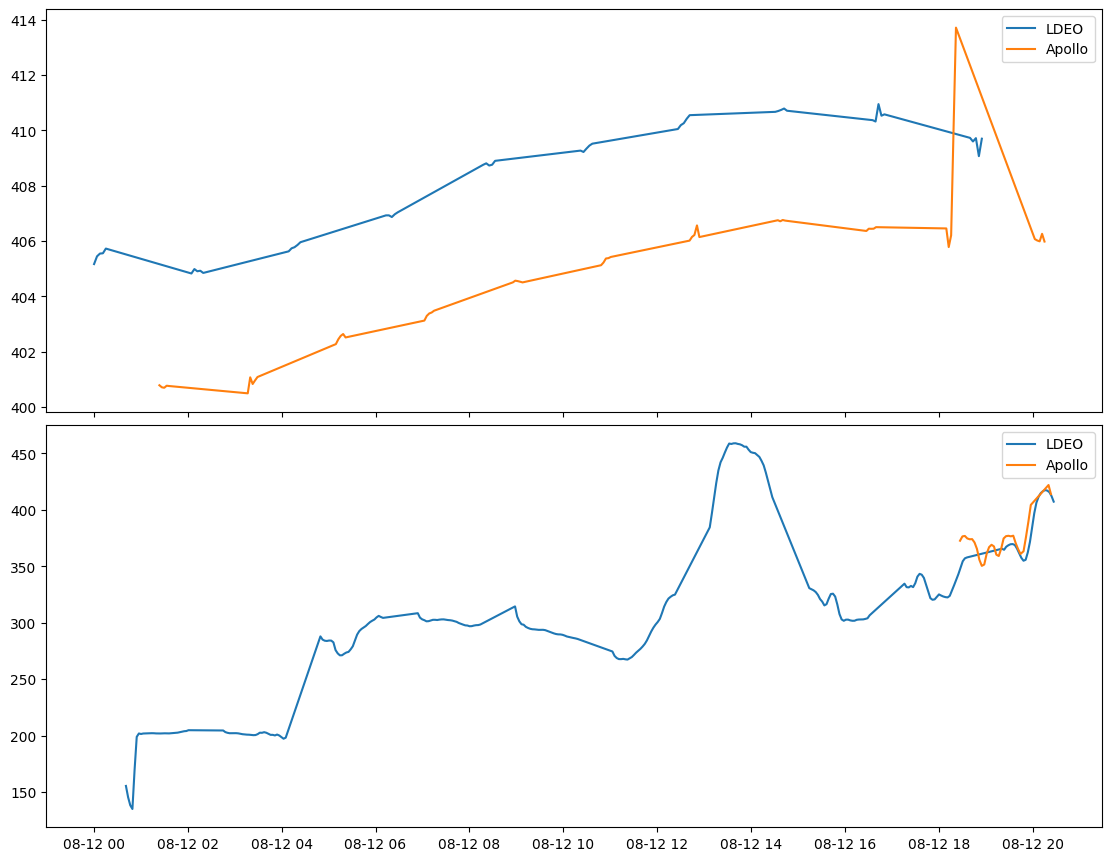

In [8]:
nrows = 2
ncols = 1
figsize = (11,8.5)

fig, ax = plt.subplots(nrows, ncols, figsize = figsize, constrained_layout = True, sharex = True)

ax[0].plot(ldeo_air.time, ldeo_air.pco2, label = 'LDEO')
ax[0].plot(apollo_air.time, apollo_air.air_pco2, label = 'Apollo')
ax[0].legend(loc = 'upper right')



ax[1].plot(ldeo_sw.time, ldeo_sw.pco2, label = 'LDEO')
ax[1].plot(apollo_sw.time, apollo_sw.sea_water_pco2, label = 'Apollo')
ax[1].legend(loc = 'upper right')
